In [1]:
from aipy.coord import rot_m, xyz2thphi
import healpy
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [2]:
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = jnp.cos(ang); s = jnp.sin(ang); C = 1-c
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=jnp.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

def xyz2thphi(xyz):
    """Convert xyz vectors (x,y,z along first axis) into angles theta
    (from z axis), phi (counter-clockwise around z, 0 at x axis)."""
    x,y,z = xyz
    phi = jnp.arctan2(y, x)
    th = jnp.arctan2(jnp.sqrt(x**2+y**2),z)
    # if jnp.ma.isMA(x):
    #     try:
    #         return jnp.ma.array([th.filled(0),phi.filled(0)],
    #             mask=[x.mask,x.mask], dtype=jnp.double)
    #     except(jnp.core.ma.MAError):
    #         return jnp.ma.array([th,phi], dtype=jnp.double)
    return jnp.array([th,phi], dtype=jnp.double)

In [3]:
dtype_r = jnp.float64
DEFAULT_NSIDE = 32
DEFAULT_NPIX = healpy.nside2npix(DEFAULT_NSIDE)
px = jnp.arange(DEFAULT_NPIX)
th, phi = healpy.pix2ang(DEFAULT_NSIDE, px)
DEFAULT_BEAM_TH = jnp.cos(th)**2 * jnp.cos(phi)**2
DEFAULT_BEAM_PHI = jnp.cos(th)**2 * jnp.sin(phi)**2

class RotatingAntenna:
    def __init__(self, beam_th=DEFAULT_BEAM_TH, beam_phi=DEFAULT_BEAM_PHI):
        self.nside = healpy.npix2nside(beam_th.size)
        self.pwr_beam_th = beam_th
        self.pwr_beam_phi = beam_phi
        self.el_axis = jnp.array([1, 0, 0], dtype=dtype_r)
        self.az_axis = jnp.array([0, 0, 1], dtype=dtype_r)

    def rotation(self, az, el):
        R_az = rot_m(az, self.az_axis)
        R_el = rot_m(el, self.el_axis)
        return R_el @ R_az

    def r_hat(self, th, phi):
        shape = th.shape
        r_hat = jnp.empty(shape + (3,), dtype=dtype_r)
        # r_hat[..., 2] = jnp.cos(th)
        r_hat = r_hat.at[..., 2].set(jnp.cos(th))
        xy = jnp.sin(th)
        # r_hat[..., 0] = jnp.cos(phi) * xy
        # r_hat[..., 1] = jnp.sin(phi) * xy
        r_hat = r_hat.at[..., 0].set(jnp.cos(phi) * xy)
        r_hat = r_hat.at[..., 1].set(jnp.sin(phi) * xy)
        return r_hat
        
    def phi_hat(self, th, phi):
        r_hat = self.r_hat(th, phi)
        phi_hat = jnp.cross(jnp.array([0, 0, 1]), r_hat)
        phi_hat /= jnp.linalg.norm(phi_hat, axis=-1, keepdims=True)
        return phi_hat

    def th_hat(self, th, phi):
        r_hat = self.r_hat(th, phi)
        phi_hat = self.phi_hat(th, phi)
        return jnp.cross(r_hat, phi_hat)

    def ang2pix(self, th, phi):
        return healpy.ang2pix(self.nside, th, phi)
    
    def sample_beam_th(self, th, phi):
        px = self.ang2pix(th, phi)
        return self.pwr_beam_th[px]
        
    def sample_beam_phi(self, th, phi):
        px = self.ang2pix(th, phi)
        return self.pwr_beam_phi[px]

    def power_transmitter(self, tx_ant, az, el):
        rot_m = self.rotation(az, el)
        th_tx, phi_tx = tx_ant.heading_thphi(rot_m)
        E_tx_rot = tx_ant.E_rotated(rot_m)
        px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th = self.pwr_beam_th[px] * E_tx_th**2
        P_rx_phi = self.pwr_beam_phi[px] * E_tx_phi**2
        P_rx = P_rx_th + P_rx_phi
        return P_rx
    
    def power_transmitter_jax(self, tx_ant, rot_m, th_tx, phi_tx, px):
        # rot_m = self.rotation(az, el)
        # th_tx, phi_tx = tx_ant.heading_thphi(rot_m)
        E_tx_rot = tx_ant.E_rotated(rot_m)
        # px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th = self.pwr_beam_th[px] * E_tx_th**2
        P_rx_phi = self.pwr_beam_phi[px] * E_tx_phi**2
        P_rx = P_rx_th + P_rx_phi
        return P_rx
    def power_transmitter_jax_pure(self, tx_ant, rot_m, th_tx, phi_tx, px,
                                   pwr_beam_th, pwr_beam_phi):
        # Same geometry as before
        E_tx_rot = tx_ant.E_rotated(rot_m)
        th_hat   = self.th_hat(th_tx, phi_tx)
        phi_hat  = self.phi_hat(th_tx, phi_tx)
    
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
    
        # px may be a traced scalar — make sure it’s an int and use dynamic indexing
        px = jax.lax.convert_element_type(px, jnp.int64)
        g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
        g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)
    
        P_rx_th  = g_th  * (E_tx_th  ** 2)
        P_rx_phi = g_phi * (E_tx_phi ** 2)
        return P_rx_th + P_rx_phi        

class TransmitterAntenna:
    def __init__(self, E1=1.0, E2=0.0, heading_top=jnp.array([0, 0, -1], dtype=dtype_r)):
        self.E1 = E1
        self.E2 = E2
        self.heading_top = heading_top
        self.ax1_top = jnp.array([1, 0, 0], dtype=dtype_r)
        self.ax2_top = jnp.array([0, 1, 0], dtype=dtype_r)

    def E_top(self):
        return self.E1 * self.ax1_top + self.E2 * self.ax2_top

    def E_rotated(self, ant_rot_m):
        irot_m = jnp.linalg.inv(ant_rot_m)
        return irot_m @ self.E_top()

    def heading_rotated(self, ant_rot_m):
        irot_m = jnp.linalg.inv(ant_rot_m)
        return irot_m @ self.heading_top
        
    def heading_thphi(self, ant_rot_m):
        heading_rot = self.heading_rotated(ant_rot_m)
        return xyz2thphi(heading_rot)

In [4]:
# def power_transmitter_jax_pure(self, tx_ant, rot_m, th_tx, phi_tx, px,
#                                pwr_beam_th, pwr_beam_phi):
#     # Geometry is unchanged
#     E_tx_rot = tx_ant.E_rotated(rot_m)
#     th_hat   = self.th_hat(th_tx, phi_tx)
#     phi_hat  = self.phi_hat(th_tx, phi_tx)

#     E_tx_th  = jnp.dot(E_tx_rot, th_hat)
#     E_tx_phi = jnp.dot(E_tx_rot, phi_hat)

#     # Robust dynamic indexing when px is traced
#     # px = jax.lax.convert_element_type(px, jnp.int32)
#     px = jax.lax.convert_element_type(px, jnp.int64)
#     g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
#     g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)

#     return g_th * (E_tx_th ** 2) + g_phi * (E_tx_phi ** 2)

# # Attach to your class if you prefer method style:
# # RXClass.power_transmitter_jax_pure = power_transmitter_jax_pure


# # ---------------------------------------------------------------------------
# # 2) Precompute coords outside of jit (your original version kept)
# #    Returns: (rs, th_txs, phi_txs, pxs) with pxs as int32
# # ---------------------------------------------------------------------------
# def px_th_ph(rx, tx, az, el):
#     n = el.shape[0]
#     # pxs    = jnp.zeros(n, dtype=jnp.int32)
#     pxs    = jnp.zeros(n, dtype=jnp.int64)
#     th_txs = jnp.zeros(n)
#     phi_txs= jnp.zeros(n)
#     rs     = jnp.zeros((n, 3, 3))
#     for i in range(n):
#         r = rx.rotation(az[i], el[i])
#         th_tx, phi_tx = tx.heading_thphi(r)
#         px = rx.ang2pix(th_tx, phi_tx)
#         pxs     = pxs.at[i].set(px)
#         th_txs  = th_txs.at[i].set(th_tx)
#         phi_txs = phi_txs.at[i].set(phi_tx)
#         rs      = rs.at[i].set(r)
#     # print('Finished Calculating Coords')
#     return rs, th_txs, phi_txs, pxs


# # ---------------------------------------------------------------------------
# # 3) Loss that updates beam arrays FUNCTIONALLY and returns them as aux
# # ---------------------------------------------------------------------------
# def loss_with_aux(W, P, coord, pbt, pbp, rx):
#     e1, e2, th, ph = W                 # scalars (0-D JAX arrays)
#     r, th_tx, phi_tx, px = coord       # r:(3,3), the rest scalars
#     # px = jax.lax.convert_element_type(px, jnp.int32)
#     px = jax.lax.convert_element_type(px, jnp.int64)

#     # Functional updates to the beam arrays at this px
#     pbt_next = pbt.at[px].set(th)
#     pbp_next = pbp.at[px].set(ph)

#     # Build per-step transmitter from W
#     tx_step = TransmitterAntenna(E1=e1, E2=e2)

#     # PURE forward — pass the updated beam arrays explicitly
#     model = rx.power_transmitter_jax_pure(
#         tx_step, r, th_tx, phi_tx, px,
#         pwr_beam_th=pbt_next,
#         pwr_beam_phi=pbp_next
#     )

#     loss = jnp.mean((model - P) ** 2)
#     return loss, (pbt_next, pbp_next)


# # ---------------------------------------------------------------------------
# # 4) A compiled "train N steps" using lax.fori_loop (inner loop)
# #    Carries (W, opt_state, pbt, pbp). Prints every 'print_every' steps.
# # ---------------------------------------------------------------------------
# def make_trainer(optimizer, rx, steps: int = 500, print_every: int = 100):
#     def train_once(W0, Pj, coord_j, pbt0, pbp0):
#         opt_state0 = optimizer.init(W0)

#         def body(i, carry):
#             W, opt_state, pbt, pbp = carry

#             (loss, (pbt_next, pbp_next)), grads = jax.value_and_grad(
#                 lambda W_: loss_with_aux(W_, Pj, coord_j, pbt, pbp, rx),
#                 has_aux=True
#             )(W)

#             updates, opt_state = optimizer.update(grads, opt_state, W)
#             W = optax.apply_updates(W, updates)

#             # Optional debug print inside jit (safe)
#             # jax.lax.cond(
#                 # jnp.equal((i + 1) % print_every, 0),
#                 # lambda _: jax.debug.print("step {i:4d} | loss {l:.6f}", i=i+1, l=loss),
#                 # lambda _: None,
#                 # operand=None,
#             # )
#             return (W, opt_state, pbt_next, pbp_next)

#         Wf, opt_statef, pbtf, pbpf = jax.lax.fori_loop(0, steps, body, (W0, opt_state0, pbt0, pbp0))
#         # Optional final loss:
#         lf, _ = loss_with_aux(Wf, Pj, coord_j, pbtf, pbpf, rx)
#         return Wf, opt_statef, pbtf, pbpf, lf

#     return jax.jit(train_once)


# # ---------------------------------------------------------------------------
# # 5) High-level driver: iterates over j (columns), runs compiled inner loop
# # ---------------------------------------------------------------------------
# def beam_finder(tx, rx, P, az, el, guesses):
#     # Precompute coords (px_th_ph uses Python loops; that’s fine here)
#     coords = px_th_ph(rx, tx, az, el)      # (rs, th_txs, phi_txs, pxs)
#     # Ensure pxs are int32 (px_th_ph already does this; keeping defensively)
#     # coords = (coords[0], coords[1], coords[2], coords[3].astype(jnp.int32))
#     coords = (coords[0], coords[1], coords[2], coords[3].astype(jnp.int64))

#     # Copy base beam arrays once; carry & update them across j
#     pwr_beam_th = rx.pwr_beam_th.copy()
#     pwr_beam_ph = rx.pwr_beam_phi.copy()

#     # Optimizer and compiled trainer
#     opt = optax.adam(1e-2)
#     trainer = make_trainer(opt, rx, steps=2000, print_every=1000)

#     # guesses has shape (4, N); we solve column-by-column
#     W  = guesses
#     Ws = jnp.zeros_like(W)

#     n = el.shape[0]
#     for j in range(n):
#         w0 = W[:, j]                                   # (4,)
#         Pj = P[j]
#         coord_j = jax.tree_map(lambda x: x[j], coords) # (r_j, th_tx_j, phi_tx_j, px_j)

#         # Run 500 Adam steps in compiled JAX
#         w, _, pwr_beam_th, pwr_beam_ph, final_loss = trainer(
#             w0, Pj, coord_j, pwr_beam_th, pwr_beam_ph
#         )

#         Ws = Ws.at[:, j].set(w)
#         # print(f'finished j={j}, loss={float(final_loss):.6f}')

#     # Return per-column solutions and the final beam arrays
#     return Ws, pwr_beam_th, pwr_beam_ph

In [5]:
def power_transmitter_jax_pure(self, tx_ant, rot_m, th_tx, phi_tx, px,
                               pwr_beam_th, pwr_beam_phi):
    # Geometry is unchanged
    E_tx_rot = tx_ant.E_rotated(rot_m)
    th_hat   = self.th_hat(th_tx, phi_tx)
    phi_hat  = self.phi_hat(th_tx, phi_tx)

    E_tx_th  = jnp.dot(E_tx_rot, th_hat)
    E_tx_phi = jnp.dot(E_tx_rot, phi_hat)

    # Robust dynamic indexing when px is traced
    # px = jax.lax.convert_element_type(px, jnp.int32)
    px = jax.lax.convert_element_type(px, jnp.int64)
    g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
    g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)

    return g_th * (E_tx_th ** 2) + g_phi * (E_tx_phi ** 2)

# Attach to your class if you prefer method style:
# RXClass.power_transmitter_jax_pure = power_transmitter_jax_pure


# ---------------------------------------------------------------------------
# 2) Precompute coords outside of jit (your original version kept)
#    Returns: (rs, th_txs, phi_txs, pxs) with pxs as int32
# ---------------------------------------------------------------------------
def px_th_ph(rx, tx, az, el):
    n = el.shape[0]
    # pxs    = jnp.zeros(n, dtype=jnp.int32)
    pxs    = jnp.zeros(n, dtype=jnp.int64)
    th_txs = jnp.zeros(n)
    phi_txs= jnp.zeros(n)
    rs     = jnp.zeros((n, 3, 3))
    for i in range(n):
        r = rx.rotation(az[i], el[i])
        th_tx, phi_tx = tx.heading_thphi(r)
        px = rx.ang2pix(th_tx, phi_tx)
        pxs     = pxs.at[i].set(px)
        th_txs  = th_txs.at[i].set(th_tx)
        phi_txs = phi_txs.at[i].set(phi_tx)
        rs      = rs.at[i].set(r)
    # print('Finished Calculating Coords')
    return rs, th_txs, phi_txs, pxs

# same forward you already use
def predict_power_with_gains(rx, tx_const, r, th_tx, phi_tx, gth, gphi):
    E_tx_rot = tx_const.E_rotated(r)
    th_hat   = rx.th_hat(th_tx, phi_tx)
    phi_hat  = rx.phi_hat(th_tx, phi_tx)
    E_th  = jnp.dot(E_tx_rot, th_hat)
    E_phi = jnp.dot(E_tx_rot, phi_hat)
    return gth * (E_th**2) + gphi * (E_phi**2)

def make_trainer_beams_direct(optimizer, rx, tx_const, steps=500):
    """Optimize g = [gth, gphi] directly; project to g>=0 after each step."""
    def train_once(g0, Pj_linear, coord_j):
        opt_state0 = optimizer.init(g0)

        def loss_fn(g):
            r, th_tx, phi_tx, _px = coord_j  # px not needed here
            pred = predict_power_with_gains(rx, tx_const, r, th_tx, phi_tx,
                                            g[0], g[1])
            return jnp.mean((pred - Pj_linear)**2)

        def body(i, carry):
            g, opt_state = carry
            l, grads = jax.value_and_grad(loss_fn)(g)
            updates, opt_state = optimizer.update(grads, opt_state, g)
            g = optax.apply_updates(g, updates)
            g = jnp.maximum(g, 0.0)   # **projection** to keep gains ≥ 0
            return (g, opt_state)

        gf, opt_statef = jax.lax.fori_loop(0, steps, body, (g0, opt_state0))
        lf = loss_fn(gf)
        return gf, opt_statef, lf

    return jax.jit(train_once)

def db_to_linear(P_db):  # if your P is in dB/dBm
    return 10.0 ** (P_db / 10.0)

def fit_beams_only_direct(rx, tx, az, el, P, E1_const, E2_const,
                          guesses_gains, steps=500, lr=1e-3, P_is_db=False):
    """
    guesses_gains: (2, N) initial *gains* for [gth, gphi] per sample (e.g., ones).
    Returns:
      gth_vec, gphi_vec: (N,) fitted gains (non-negative),
      pxs: (N,) pixel indices,
      G: (2, N) final gains (same as stacking the two vectors),
      final_losses: (N,) float64 final loss per sample.
    """
    # geometry & pixel indices
    rs, th_txs, phi_txs, pxs = px_th_ph(rx, tx, az, el)
    pxs = pxs.astype(jnp.int64)

    # constant transmitter with known E's
    tx_const = TransmitterAntenna(E1=E1_const, E2=E2_const)

    opt = optax.adam(lr)
    trainer = make_trainer_beams_direct(opt, rx, tx_const, steps=steps)

    N = el.shape[0]
    G = guesses_gains.copy()                 # (2, N) gains
    gth_vec  = jnp.zeros(N)
    gphi_vec = jnp.zeros(N)
    final_losses = np.empty(N, dtype=np.float64)

    for j in range(N):
        g0 = G[:, j]                                   # (2,) gains init
        Pj = P[j]
        Pj_linear = db_to_linear(Pj) if P_is_db else Pj
        coord_j = (rs[j], th_txs[j], phi_txs[j], pxs[j])

        gf, _, lf = trainer(g0, Pj_linear, coord_j)
        final_losses[j] = float(jax.device_get(lf))

        # store fitted gains
        G = G.at[:, j].set(gf)
        gth_vec  = gth_vec.at[j].set(gf[0])
        gphi_vec = gphi_vec.at[j].set(gf[1])

    return gth_vec, gphi_vec, pxs, G, final_losses

In [112]:
# freq_path = 'Freq_9765620Hz.csv'
freq_path = 'Freq_11718745Hz.csv'
total_theta = np.loadtxt('/home/dominiv/eigsep/data/july2025/beam_results/Gain_Theta/' + freq_path, delimiter=',', skiprows=1)
total_phi = np.loadtxt('/home/dominiv/eigsep/data/july2025/beam_results/Gain_Phi/' + freq_path, delimiter=',', skiprows=1)

theta_sim = total_theta[:, 1]
phi_sim = total_theta[:, 0]

sim_map_th = total_theta[:, 2]
sim_map_ph = total_phi[:, 2]

In [113]:
theta_chat = jnp.deg2rad(np.clip(theta_sim, 0.0, 180.0))        # -> [0, pi]
phi_chat   = jnp.deg2rad((phi_sim + 360.0) % 360.0)     

NSIDE = DEFAULT_NSIDE  # or pick another; 74 is close for ~65k samples
NPIX = DEFAULT_NPIX
pix = healpy.ang2pix(NSIDE, theta_chat, phi_chat, nest=False)

counts = jnp.bincount(pix, minlength=NPIX)
sums   = jnp.bincount(pix, weights=sim_map_th, minlength=NPIX)

m_th = np.full(NPIX, healpy.UNSEEN, dtype=float)   # RING-ordered map
mask = counts > 0
m_th[mask] = sums[mask] / counts[mask]

In [114]:
theta_chat = jnp.deg2rad(np.clip(theta_sim, 0.0, 180.0))        # -> [0, pi]
phi_chat   = jnp.deg2rad((phi_sim + 360.0) % 360.0)     

NSIDE = DEFAULT_NSIDE  # or pick another; 74 is close for ~65k samples
NPIX = DEFAULT_NPIX
pix = healpy.ang2pix(NSIDE, theta_chat, phi_chat, nest=False)

counts = jnp.bincount(pix, minlength=NPIX)
sums   = jnp.bincount(pix, weights=sim_map_ph, minlength=NPIX)


m_phi = np.full(NPIX, healpy.UNSEEN, dtype=float)   # RING-ordered map
mask = counts > 0
m_phi[mask] = sums[mask] / counts[mask]

In [115]:
az_range_deg = jnp.deg2rad(jnp.linspace(0.0, 360.0, 72, endpoint=False)) # orientation of the box, NOT the beam's theta and phi
el_range_deg = jnp.deg2rad(jnp.linspace(0.0, 360.0, 72, endpoint=False))
el = []
az = []
el_axs = el_range_deg.copy()
for av in az_range_deg:
    for ev in el_axs:
        el.append(ev)
        az.append(av)
    el_axs = el_axs[::-1]
el = jnp.array(el)
az = jnp.array(az)

In [116]:
def simulate_powers_vmap(rx, tx, az, el, E1, E2, pwr_beam_th=None, pwr_beam_phi=None):
    if pwr_beam_th is None: pwr_beam_th = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi

    # Precompute geometry for all samples (your helper)
    rs, th_txs, phi_txs, pxs = px_th_ph(rx, tx, az, el)  # pxs should already be int32

    tx_ant = TransmitterAntenna(E1=E1, E2=E2)

    def _forward(r, th_tx, phi_tx, px):
        return rx.power_transmitter_jax_pure(
            tx_ant, r, th_tx, phi_tx, px,
            pwr_beam_th=pwr_beam_th,
            pwr_beam_phi=pwr_beam_phi
        )

    # Vectorize over the sample dimension
    P = jax.vmap(_forward)(rs, th_txs, phi_txs, pxs)     # shape: (N,)
    return P

def power_sim(pwr_beam_th, pwr_beam_phi, E_tx_th, E_tx_phi):
    return pwr_beam_th * (E_tx_th ** 2) + pwr_beam_phi * (E_tx_phi ** 2)

txe1 = 1
txe2 = 0
# target_th = DEFAULT_BEAM_TH * 1.3
# target_ph = DEFAULT_BEAM_PHI * 1.3
target_th = m_th
target_ph = m_phi
rx_target = RotatingAntenna(beam_th=target_th, beam_phi=target_ph)
tx_target = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=jnp.array([0, 0, -1]))
target_p = simulate_powers_vmap(rx_target, tx_target, az, el, E1=txe1, E2=txe2)

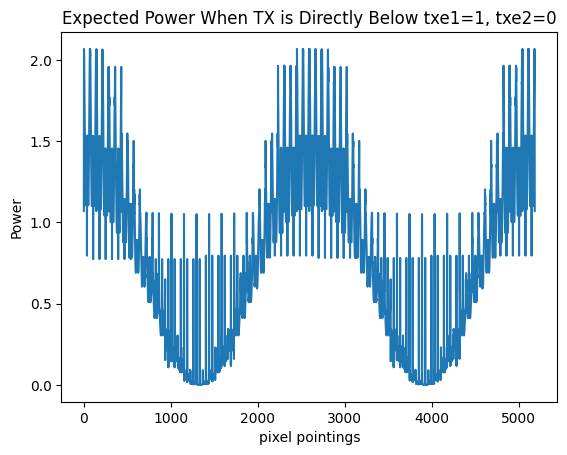

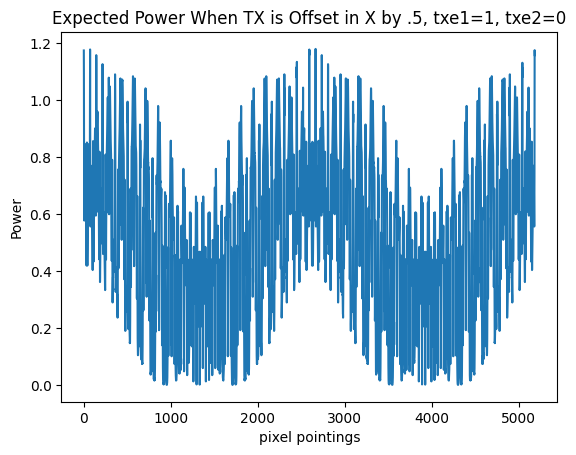

In [59]:

rx_target = RotatingAntenna(beam_th=target_th, beam_phi=target_ph)
tx_target = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=jnp.array([.5, 0, -1]))
target_p_off = simulate_powers_vmap(rx_target, tx_target, az, el, E1=txe1, E2=txe2)

plt.figure()
plt.plot(target_p)
plt.xlabel('pixel pointings')
plt.ylabel('Power')
plt.title(f'Expected Power When TX is Directly Below {txe1=}, {txe2=}')
plt.show()

plt.figure()
plt.plot(target_p_off)
plt.xlabel('pixel pointings')
plt.ylabel('Power')
plt.title(f'Expected Power When TX is Offset in X by .5, {txe1=}, {txe2=}')
plt.show()

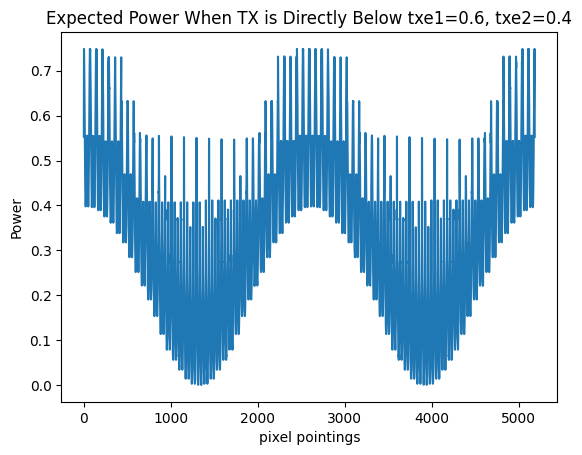

In [56]:
plt.figure()
plt.plot(target_p)
plt.xlabel('pixel pointings')
plt.ylabel('Power')
plt.title(f'Expected Power When TX is Directly Below {txe1=}, {txe2=}')
plt.show()

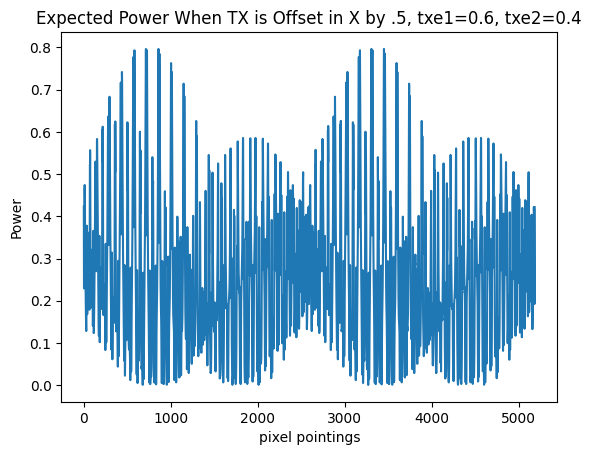

In [57]:
rx_target = RotatingAntenna(beam_th=target_th, beam_phi=target_ph)
tx_target = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=jnp.array([.5, 0, -1]))
target_p_off = simulate_powers_vmap(rx_target, tx_target, az, el, E1=txe1, E2=txe2)

plt.figure()
plt.plot(target_p_off)
plt.xlabel('pixel pointings')
plt.ylabel('Power')
plt.title(f'Expected Power When TX is Offset in X by .5, {txe1=}, {txe2=}')
plt.show()

In [117]:
diff_th = jnp.ones_like(DEFAULT_BEAM_TH) + 3
diff_ph = jnp.ones_like(DEFAULT_BEAM_PHI) + 2
rx_diff = RotatingAntenna(beam_th=diff_th, beam_phi=diff_ph)
tx_diff = TransmitterAntenna(E1=txe1, E2=txe2)
guess_coord = px_th_ph(rx_diff, tx_diff, az, el)
guess_coords = tuple( x.astype(jnp.int64) if i == 3 else x
            for i, x in enumerate(guess_coord) )
pxs = guess_coords[3]

th_guess = diff_th[pxs]
ph_guess = diff_ph[pxs]
g_W = jnp.stack((th_guess, ph_guess), axis=0)
const_g = fit_beams_only_direct(rx_diff, tx_diff, az, el, target_p, txe1, txe2, g_W, steps=10000, lr=1e-2)

In [118]:


# uses your existing helpers
# - px_th_ph(rx, tx, az, el)
# - predict_power_with_gains(rx, tx_const, r, th_tx, phi_tx, gth, gphi)

def db_to_linear(P_db):    # only if your targets are in dB/dBm
    return 10.0 ** (P_db / 10.0)

def linear_to_db(P_lin, eps=1e-12):
    return 10.0 * jnp.log10(P_lin + eps)

def power_from_fits_with_original_E(rx, tx_geom, az, el,
                                    gth_vec, gphi_vec,
                                    E1_orig, E2_orig,
                                    P_target=None, P_is_db=False):
    """
    Rebuild predicted powers using fitted gains and the ORIGINAL (E1,E2).
    - rx: your receiver
    - tx_geom: a TX instance used ONLY for geometry (heading_thphi). Its E1/E2 don't matter here.
    - az, el: (N,) measurement directions
    - gth_vec, gphi_vec: (N,) fitted gains per sample (from your fitter)
    - E1_orig, E2_orig: the original transmitter polarization used to make the target power
    - P_target: optional (N,) target power to compare against
    - P_is_db: set True if P_target is in dB/dBm

    Returns:
      P_pred_lin: (N,) predicted powers in linear units
      metrics: dict with simple comparison stats (present only if P_target is given)
      (also returns P_pred_db in metrics if you passed a dB target)
    """
    # 1) Recompute geometry
    rs, th_txs, phi_txs, pxs = px_th_ph(rx, tx_geom, az, el)

    # 2) Build a TX with the *original* E's
    tx_orig = TransmitterAntenna(E1=E1_orig, E2=E2_orig)

    # 3) Predict power for each sample using fitted gains
    def one(r, th_tx, phi_tx, gth, gphi):
        return predict_power_with_gains(rx, tx_orig, r, th_tx, phi_tx, gth, gphi)

    P_pred_lin = jax.vmap(one)(rs, th_txs, phi_txs, gth_vec, gphi_vec)  # (N,)

    # 4) Optional comparison to target
    metrics = None
    if P_target is not None:
        if P_is_db:
            P_t_lin = db_to_linear(P_target)
        else:
            P_t_lin = P_target

        # simple stats in linear domain
        err = P_pred_lin - P_t_lin
        mse = jnp.mean(err**2)
        rmse = jnp.sqrt(mse)
        mae = jnp.mean(jnp.abs(err))
        rel_mae = jnp.mean(jnp.abs(err) / (P_t_lin + 1e-12))
        # R^2
        var = jnp.var(P_t_lin)
        r2 = 1.0 - (mse / (var + 1e-12))

        metrics = {
            "rmse_lin": float(rmse),
            "mae_lin": float(mae),
            "rel_mae_lin": float(rel_mae),
            "r2_lin": float(r2),
        }

        # if target was in dB, also give dB-space comparison for sanity plots
        if P_is_db:
            P_pred_db = linear_to_db(P_pred_lin)
            metrics.update({
                "rmse_db": float(jnp.sqrt(jnp.mean((P_pred_db - P_target)**2))),
                "mae_db": float(jnp.mean(jnp.abs(P_pred_db - P_target))),
            })

    return P_pred_lin, metrics


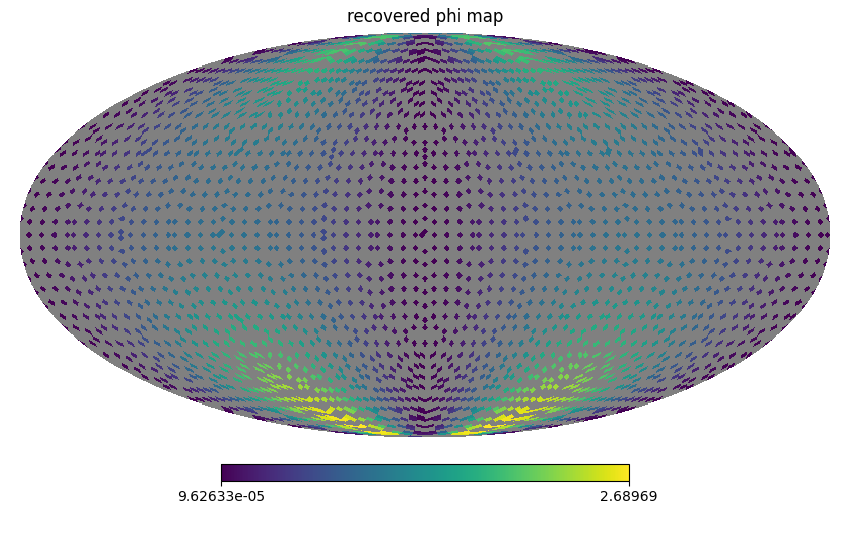

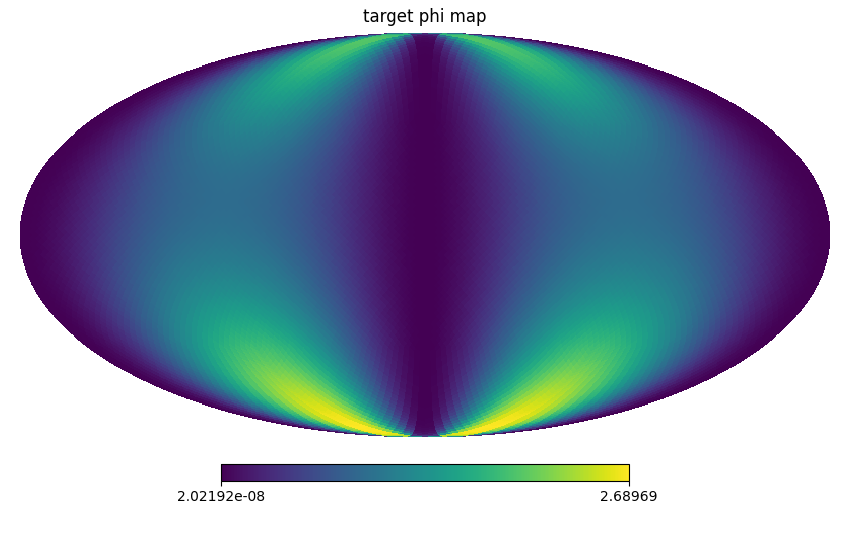

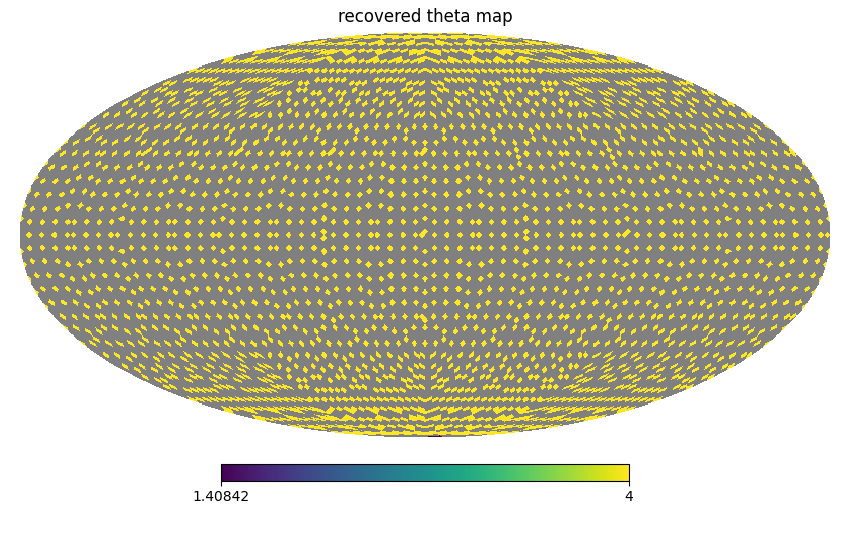

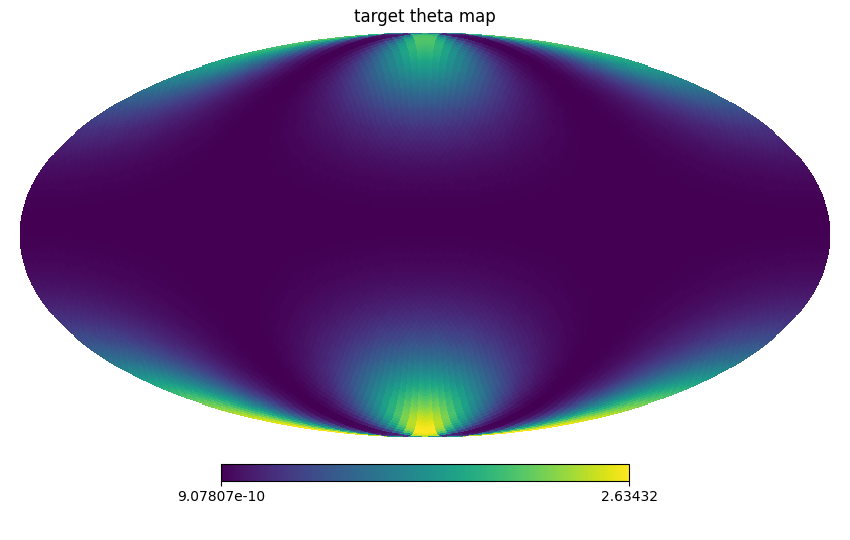

In [119]:
fit_px = const_g[2]
empty_map_ph = np.full_like(DEFAULT_BEAM_PHI, healpy.UNSEEN)
empty_map_ph[fit_px] = const_g[1]
empty_map_th = np.full_like(DEFAULT_BEAM_TH, healpy.UNSEEN)
empty_map_th[fit_px] = const_g[0]
healpy.mollview(empty_map_ph    , title='recovered phi map')
healpy.mollview(target_ph, title='target phi map')
healpy.mollview(empty_map_th    , title='recovered theta map', rot=(90, 0, 0))
healpy.mollview(target_th , title='target theta map')

In [107]:
matplotlib widget

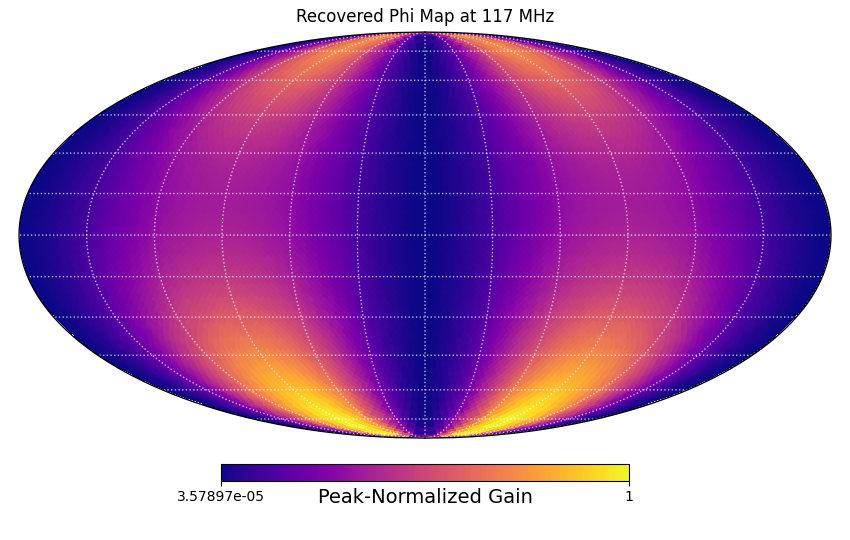

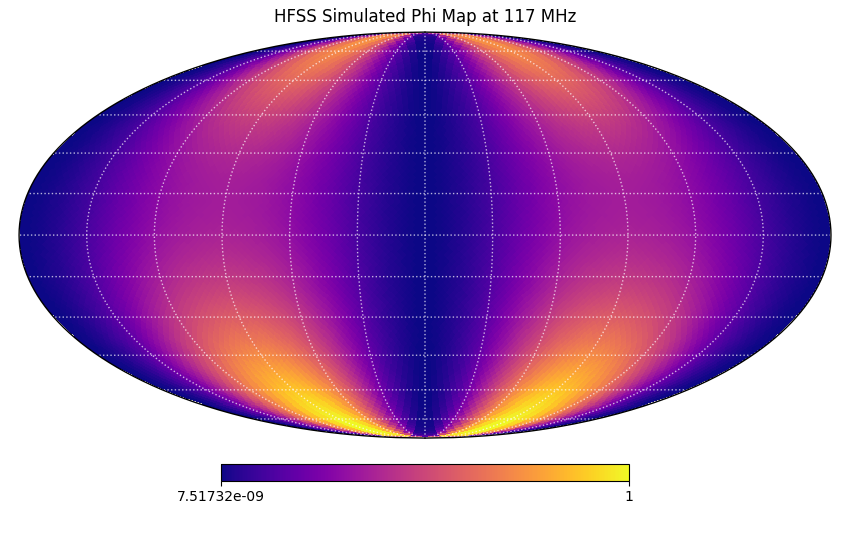

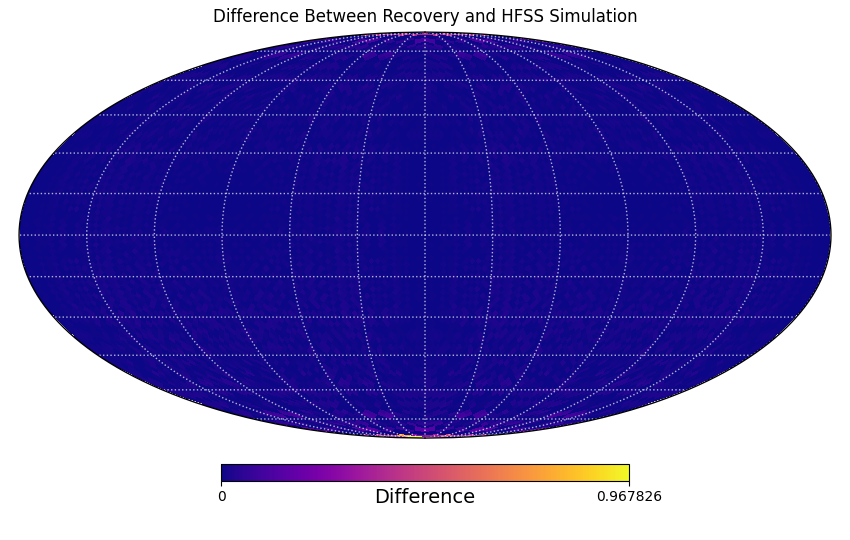

In [123]:
import numpy as np
from scipy.spatial import cKDTree

# together_rec = empty_map_th + empty_map_ph
m = empty_map_ph.copy()
# m = together_rec.copy()
nside = healpy.get_nside(m)

# Build masks (treat UNSEEN and non-finite as missing)
missing = (m == healpy.UNSEEN) | ~np.isfinite(m)
valid   = ~missing

pix_valid   = np.where(valid)[0]
pix_missing = np.where(missing)[0]

# Unit vectors for pixel centers
v_valid   = np.array(healpy.pix2vec(nside, pix_valid)).T   # shape (Nv, 3)
v_missing = np.array(healpy.pix2vec(nside, pix_missing)).T # shape (Nm, 3)

# Nearest neighbors in 3D (unit sphere)
tree = cKDTree(v_valid)
k = 8  # try 4–16; larger = smoother
dist, idx = tree.query(v_missing, k=k)   # shapes (Nm, k)

# Inverse-distance weights (robustify tiny distances)
w = 1.0 / (dist + 1e-12)**2
w /= w.sum(axis=1, keepdims=True)

m_filled = m.copy()
m_filled[pix_missing] = (w * m[pix_valid][idx]).sum(axis=1)


# together_sim = target_ph + target_th

norm_sim = target_ph / jnp.max(target_ph)
norm_phi = m_filled / jnp.max(m_filled)
# diff = jnp.abs(norm_sim - norm_phi)
diff = jnp.abs(target_ph - m_filled)
# diff = np.where(np.abs(diff)>1e-3, 0, diff)
# diff = target_ph - m_filled
# diff /= jnp.max(diff)
# good_pix = np.where(diff != healpy.UNSEEN)
# map_diff = diff / norm_sim * 100
# map_diff = np.divide(diff, norm_sim, out=np.zeros_like(diff), where=norm_sim>1e-3) * 100
# map_diff = np.zeros_like(target_ph)
map_diff = np.divide(diff, target_ph, out=np.zeros_like(target_ph), where=np.abs(target_ph)>1e-3) * 100 
# map_diff = np.zeros_like(target_ph)
# np.divide(diff, target_ph, out=map_diff, where=target_ph>1e-3)
# map_diff *= 100

# err_diff = np.where(np.abs(diff) <1e-3, 0, diff)
# err_sim = np.where(np.abs(target_ph) <1e-3, 0, target_ph)
# map_diff = err_diff / err_sim * 100
# map_diff = np.divide(err_diff, err_sim, out=np.zeros_like(err_diff), where=err_sim!=0) * 100 

# m1 = norm_sim.copy()
# m2 = norm_phi.copy()
# den = np.abs(m1) + np.abs(m2)
# tau = 1e-1 * np.nanmedian(den[good])

# spd = np.zeros_like(m1, dtype=float)   # 0 where both are tiny
# mask = good & (den > tau)
# np.divide(2.0*(m1 - m2), den, out=spd, where=mask)
# spd *= 100.0


healpy.mollview(norm_phi    , title='Recovered Phi Map at 117 MHz', unit='Peak-Normalized Gain', cmap='plasma')
healpy.graticule(dpar=15, dmer=30, color="white", linestyle=":", alpha=0.7)
healpy.mollview(norm_sim    , title='HFSS Simulated Phi Map at 117 MHz', cmap='plasma')
healpy.graticule(dpar=15, dmer=30, color="white", linestyle=":", alpha=0.7)
# healpy.mollview(together_sim    , title='HFSS Simulated Phi Map at 70 MHz')
# healpy.graticule(dpar=15, dmer=30, color="white", linestyle=":", alpha=0.7)
healpy.mollview((diff)    , title='Difference Between Recovery and HFSS Simulation', unit='Difference', cmap='plasma')
healpy.graticule(dpar=15, dmer=30, color="white", linestyle=":", alpha=0.7)

In [121]:
print(np.where((diff) >= .1)[0].shape[0] / diff.shape[0])
print(np.where((diff) >= .01)[0].shape)
print(np.where((diff) >= .05)[0].shape[0] )#/ diff.shape[0])
print(np.mean(diff)*100)
print(np.max(diff))

0.0048828125
(3922,)
174
0.9180911921342464
0.9678263313982444


min |m_filled|: 1.93666e-10
# pixels with |m_filled|< 0.001 : 864


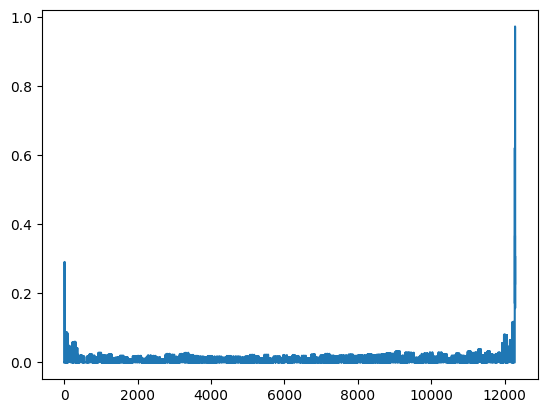

In [66]:
tol = 1e-3# * np.nanmedian(np.abs(target_th))  # pick a scale-aware tolerance
mask = np.isfinite(diff) & np.isfinite(target_th) & (np.abs(target_th) > tol)

plot_diff = np.zeros_like(diff, dtype=float)  # or np.full_like(..., np.nan, float)
np.divide(diff, target_th, out=plot_diff, where=mask)
plot_diff *= 100.0
print("min |m_filled|:", np.nanmin(np.abs(target_th)))
print("# pixels with |m_filled|<", tol, ":", np.count_nonzero(np.abs(target_th) <= tol))


plt.figure()
plt.plot(diff)
plt.show()

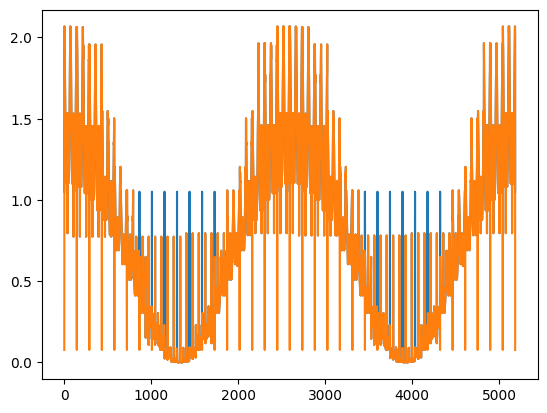

In [74]:
qu = jnp.abs(target_ph[fit_px]) - jnp.abs(empty_map_ph[fit_px])

plt.figure()
# plt.plot(qu)
plt.plot(target_ph[fit_px])
plt.plot(empty_map_ph[fit_px])
plt.show()

In [209]:
plt.close('all')

In [34]:
def simulate_powers_vmap_fit(rx, tx, az, el, E1, E2, geometry, pwr_beam_th, pwr_beam_phi):
    # if pwr_beam_th is None: pwr_beam_th = rx.pwr_beam_th
    # if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi

    # Precompute geometry for all samples (your helper)
    rs, th_txs, phi_txs, pxs = geometry  # pxs should already be int32

    tx_ant = TransmitterAntenna(E1=E1, E2=E2)

    def _forward(r, th_tx, phi_tx, px):
        return rx.power_transmitter_jax_pure(
            tx_ant, r, th_tx, phi_tx, px,
            pwr_beam_th=pwr_beam_th,
            pwr_beam_phi=pwr_beam_phi
        )

    # Vectorize over the sample dimension
    P = jax.vmap(_forward)(rs, th_txs, phi_txs, pxs)     # shape: (N,)
    return P

rec_rx = RotatingAntenna(beam_th=empty_map_th, beam_phi=empty_map_ph)
rec_power = simulate_powers_vmap_fit(rec_rx, tx_target, az, el, txe1, txe2, guess_coord, empty_map_th, empty_map_ph)

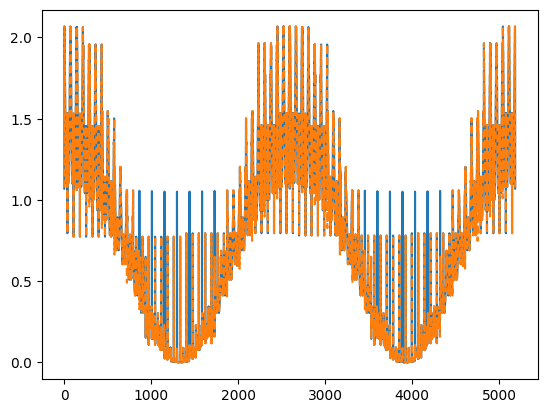

4.502533714045366e-05


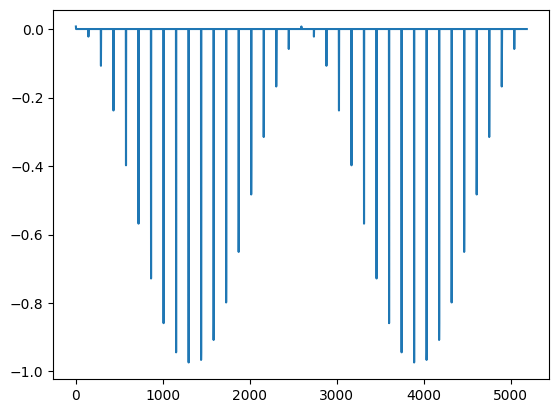

In [42]:

plt.figure()
plt.plot(target_p)
plt.plot(rec_power, ls='--')
plt.show()

print(jnp.mean(rec_power - target_p)**2)

plt.figure()
plt.plot(rec_power - target_p)
plt.show()

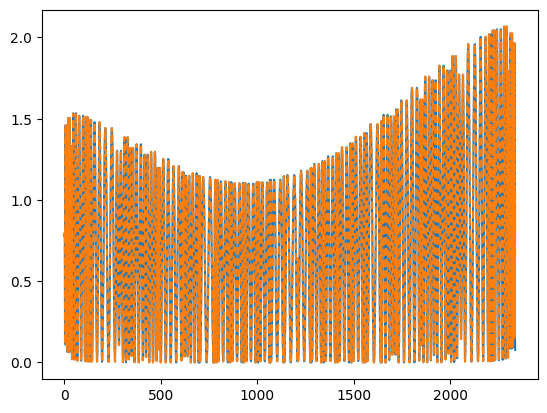

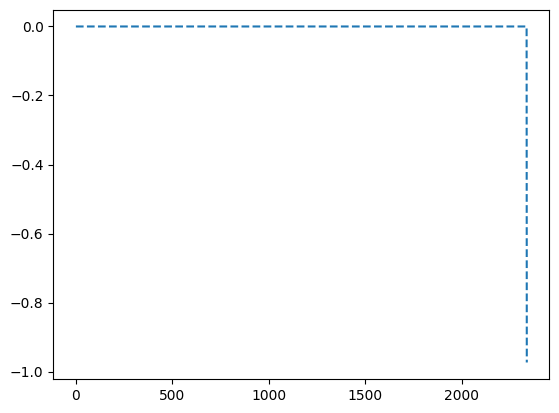

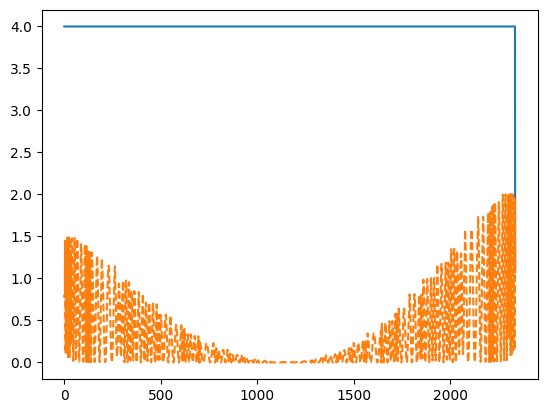

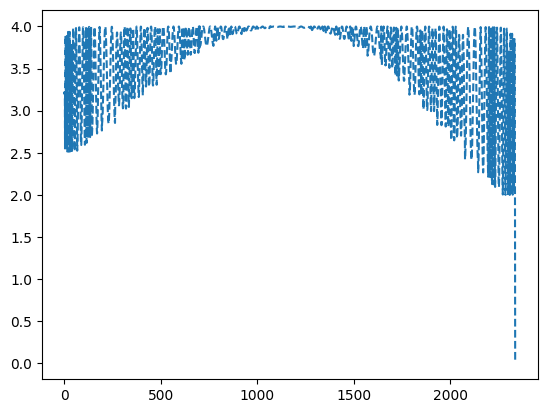

In [25]:
ix = jnp.where(empty_map_ph != healpy.UNSEEN)
plt.figure()
plt.plot(empty_map_ph[ix])
plt.plot(target_ph[ix], ls='--')
plt.show()

plt.figure()
plt.plot((empty_map_ph[ix] - target_ph[ix]), ls='--')
plt.show()

plt.figure()
plt.plot(empty_map_th[ix])
plt.plot(target_th[ix], ls='--')
plt.show()

plt.figure()
plt.plot((empty_map_th[ix] - target_th[ix]), ls='--')

plt.show()

In [17]:
def fields_weights_from_alpha(rx, rs, th_txs, phi_txs, alpha):
    """
    Given a global polarization angle alpha (E1=cos a, E2=sin a), compute
    a_j = E_theta^2, b_j = E_phi^2 for each sample j.
    """
    E1 = jnp.cos(alpha)
    E2 = jnp.sin(alpha)

    def one(r, th_tx, phi_tx):
        # If constructing a TX inside jit is problematic in your codebase,
        # replace the two lines below with a pure function that computes E_tx_rot.
        tx_ant = TransmitterAntenna(E1=E1, E2=E2)
        E_tx_rot = tx_ant.E_rotated(r)

        th_hat  = rx.th_hat(th_tx,  phi_tx)
        phi_hat = rx.phi_hat(th_tx, phi_tx)
        E_th  = jnp.dot(E_tx_rot, th_hat)
        E_phi = jnp.dot(E_tx_rot, phi_hat)
        return E_th**2, E_phi**2

    a, b = jax.vmap(one)(rs, th_txs, phi_txs)  # (N,), (N,)
    return a, b
def make_trainer_global_alpha(optimizer, rx, steps=800, log_every=None):
    """
    Optimize params = { 'G': (2,N) gains, 'alpha': scalar }.
    Loss = mean_j (G[0,j]*a_j(alpha) + G[1,j]*b_j(alpha) - P_lin[j])^2
    + (optional) extras you might add later.
    Projects gains >= 0 after each update.
    """
    log_every = int(log_every) if log_every else 0
    K = (steps // log_every) if log_every and steps >= log_every else 0

    def train(params0, P_lin, rs, th_txs, phi_txs):
        opt_state0 = optimizer.init(params0)
        if K:
            logs0 = jnp.zeros((K,), dtype=jnp.float32)
            k0 = jnp.array(0, dtype=jnp.int32)

        def loss_from_params(params):
            G = params["G"]              # (2,N)
            alpha = params["alpha"]      # scalar
            a, b = fields_weights_from_alpha(rx, rs, th_txs, phi_txs, alpha)  # (N,),(N,)
            pred = G[0] * a + G[1] * b
            return jnp.mean((pred - P_lin)**2)

        def body(i, carry):
            if K:
                params, opt_state, logs, k = carry
            else:
                params, opt_state = carry

            l, grads = jax.value_and_grad(loss_from_params)(params)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)

            # project gains >= 0 (alpha unconstrained/periodic)
            params = {
                "G": jnp.maximum(params["G"], 0.0),
                "alpha": params["alpha"]
            }

            if K:
                def write(_):
                    return (params, opt_state, logs.at[k].set(l), k + 1)
                cond = (((i + 1) % log_every) == 0)
                return jax.lax.cond(cond, write, lambda _: (params, opt_state, logs, k), operand=None)
            else:
                return (params, opt_state)

        init_carry = (params0, opt_state0, jnp.zeros((K,), jnp.float32), jnp.array(0, jnp.int32)) if K else (params0, opt_state0)
        out = jax.lax.fori_loop(0, steps, body, init_carry)

        if K:
            paramsf, opt_statef, logs, _ = out
        else:
            paramsf, opt_statef = out
            logs = jnp.zeros((0,), jnp.float32)

        lf = loss_from_params(paramsf)
        return paramsf, opt_statef, lf, logs

    return jax.jit(train)
def fit_beams_with_global_alpha(rx, tx_geom, az, el, P,
                                guesses_gains, alpha0,
                                steps=800, lr=1e-3, P_is_db=False,
                                log_every=None):
    """
    rx        : receiver object
    tx_geom   : transmitter object used only for geometry (heading_thphi).
                Polarization is controlled by alpha, not tx_geom.E1/E2.
    guesses_gains : (2,N) initial gains per sample (e.g., ones)
    alpha0        : initial alpha (radians). If you have E1,E2 guess: alpha0 = atan2(E2,E1)
    Returns:
      gth_vec, gphi_vec: (N,)
      alpha_fit: scalar
      pxs: (N,) int64 (for map-building later)
      final_loss: scalar
      loss_history: (≈ steps/log_every,) thinned if log_every is set, else empty
    """
    # Geometry & pxs
    rs, th_txs, phi_txs, pxs = px_th_ph(rx, tx_geom, az, el)  # uses tx_geom only for heading_thphi
    pxs = pxs.astype(jnp.int64)

    # Targets in linear units
    P_lin = db_to_linear(P) if P_is_db else P

    # Params init
    G0 = guesses_gains  # (2,N)
    params0 = {"G": G0, "alpha": jnp.asarray(alpha0)}

    # Optimizer + trainer
    opt = optax.adam(lr)
    trainer = make_trainer_global_alpha(opt, rx, steps=steps, log_every=log_every)

    paramsf, _, lf, logs = trainer(params0, P_lin, rs, th_txs, phi_txs)

    gth_vec  = paramsf["G"][0]
    gphi_vec = paramsf["G"][1]
    alpha_fit = paramsf["alpha"]

    return gth_vec, gphi_vec, alpha_fit, pxs, float(jax.device_get(lf)), np.asarray(jax.device_get(logs))

In [50]:
txe1 = 1
txe2 = 0
# target_th = DEFAULT_BEAM_TH * 1.3
# target_ph = DEFAULT_BEAM_PHI * 1.3
target_th = m_th
target_ph = m_phi
rx_target = RotatingAntenna(beam_th=target_th, beam_phi=target_ph)
tx_target = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=jnp.array([0, 0, -1]))
target_p = simulate_powers_vmap(rx_target, tx_target, az, el, E1=txe1, E2=txe2)

In [51]:
diff_th = jnp.ones_like(DEFAULT_BEAM_TH) + 3
diff_ph = jnp.ones_like(DEFAULT_BEAM_PHI) + 2
rx_diff = RotatingAntenna(beam_th=diff_th, beam_phi=diff_ph)
tx_diff = TransmitterAntenna(E1=txe1, E2=txe2)
guess_coord = px_th_ph(rx_diff, tx_diff, az, el)
guess_coords = tuple( x.astype(jnp.int64) if i == 3 else x
            for i, x in enumerate(guess_coord) )
pxs = guess_coords[3]

alpha0 = jnp.arctan2(txe2, txe1)  # or 0.0 for E1=1,E2=0

th_guess = diff_th[pxs]
ph_guess = diff_ph[pxs]
alpha_guess = jnp.zeros_like(th_guess)
g_W = jnp.stack((th_guess, ph_guess), axis=0)
const_g_4par = fit_beams_with_global_alpha(rx_diff, tx_diff, az, el, target_p, g_W, alpha0, steps=10000, lr=1e-1)

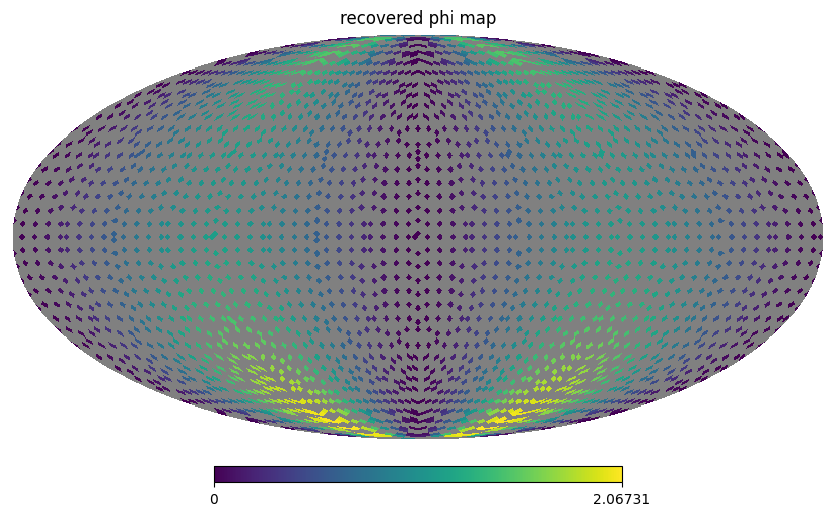

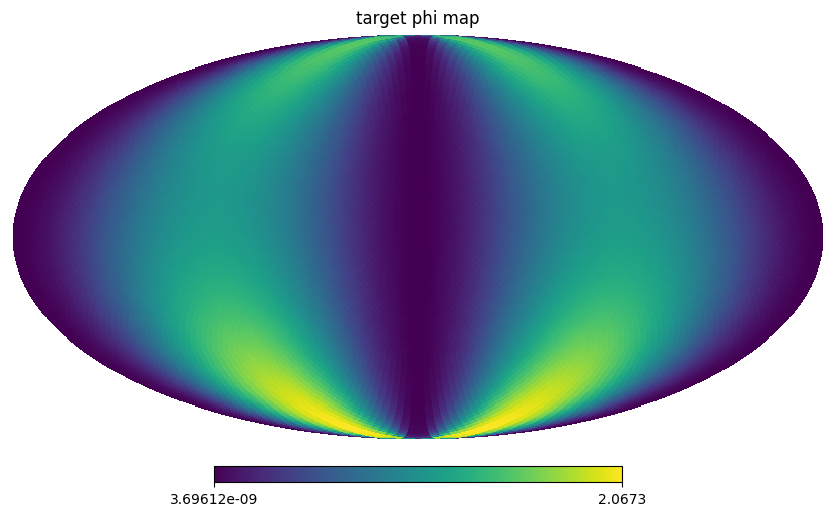

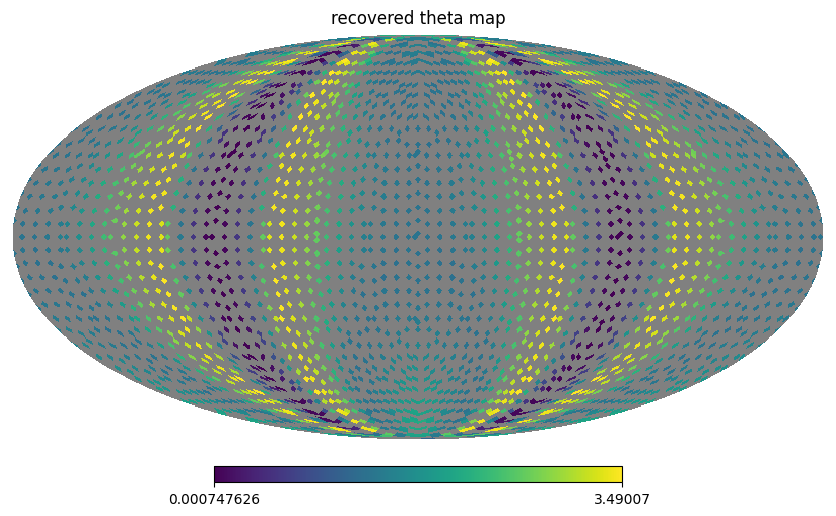

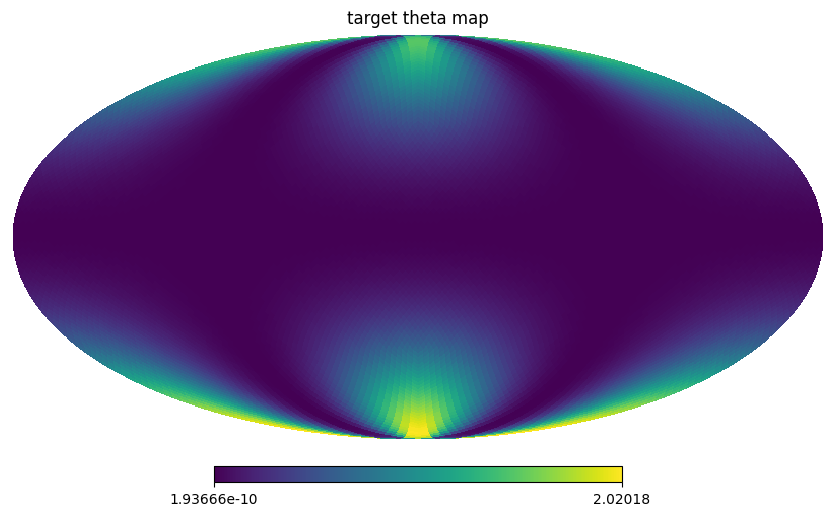

In [52]:
fit_px = const_g_4par[3]
empty_map_ph_4par = np.full_like(DEFAULT_BEAM_PHI, healpy.UNSEEN)
empty_map_ph_4par[fit_px] = const_g_4par[1]
empty_map_th_4par = np.full_like(DEFAULT_BEAM_TH, healpy.UNSEEN)
empty_map_th_4par[fit_px] = const_g_4par[0]
healpy.mollview(empty_map_ph_4par    , title='recovered phi map', rot=(0,0,0))
# healpy.mollview(DEFAULT_BEAM_PHI, title='target phi map')
healpy.mollview(target_ph, title='target phi map')
healpy.mollview(empty_map_th_4par    , title='recovered theta map', rot=(90, 0, 0))
# healpy.mollview(DEFAULT_BEAM_TH , title='target theta map')
healpy.mollview(target_th , title='target theta map')
